In [0]:
use_google_colab = True

In [2]:
# mount gdrive
if use_google_colab:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# unzip data
if use_google_colab:
    !unzip -q "/content/gdrive/My Drive/TSAI/session5/hvc_data.zip"
    # look for `hvc_annotations.csv` file and `resized` dir
    %ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [3]:
if use_google_colab:
  %tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd
import os

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.applications import VGG16

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import GlobalAveragePooling2D, Dropout, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

if use_google_colab:
    from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column

print("Shape: ", df.shape)
df.head(3)

Shape:  (13573, 9)


,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg


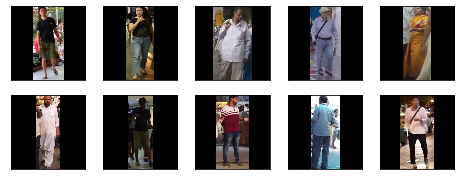

In [5]:
# visualize few images
fig = plt.figure(figsize=(8,3))
for i in range(10):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  img = image.load_img(df.image_path[i])
  plt.imshow(img)
plt.show()

In [0]:
# utility function to view image properties and its labeling
def viewData(index):
  img = image.load_img(df.image_path[index])
  plt.imshow(img)
  print(df.iloc[index])

gender                              male
imagequality                        Good
age                                25-35
weight                    normal-healthy
carryingbag     Grocery/Home/Plastic Bag
footwear                           Fancy
emotion                          Neutral
bodypose                  Front-Frontish
image_path              resized/4865.jpg
Name: 4864, dtype: object


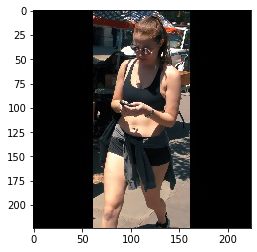

In [7]:
viewData(4864) # typical case of wrong labeling (Gender is wrongly labeled)

In [0]:
# Data set observations:
# 1. all image are of size 224X224
# 2. Majority of image have pictures at the center of the entire images i.e aroud 55 pixel at left and right are black.
# 3. Few image have worng image ofr few category.. at this moment not sure of exact quantites of wrong labelling

In [9]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

# view one-hot encoding results
one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False
batchsize = 64
data_augmentation_flag = False

In [0]:
if subtract_pixel_mean:
  train_items = train_df.iloc[:]
  train_images = np.stack([cv2.imread(item["image_path"]) for _, item in train_items.iterrows()])
  train_images = train_images.astype('float32') / 255
  train_images_mean = np.mean(train_images, axis=0)
  del train_images

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=64, shuffle=True, data_augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.data_augmentation = data_augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        # normalize the data
        image = image.astype('float32') / 255.

        if subtract_pixel_mean:
          image -= train_images_mean
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        if self.data_augmentation is not None:
            self.data_augmentation.fit(image)
            image = self.data_augmentation.flow(image, shuffle=False, batch_size=self.batch_size).next()

        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
def cutout_fxn(img):

    height = img.shape[0]
    width = img.shape[1]
    depth = img.shape[2]

    CUT_SIZE = 32 #height//4

    img_new = np.zeros((width+2*CUT_SIZE,height+2*CUT_SIZE, depth), np.float32)

    # take the mean of only center portion.. don't consider black area of eaither side of the image
    # after analysing the few images it is found that actual pictures are
    # at center of the image so cutout to be position accordingly
    # cutout not applie don black region
    offset = 67 # ofset of left and right side of image of balck portion

    mean = np.mean(img[:,offset:-offset:], axis=(0, 1))
    img -= mean

    img_new[CUT_SIZE:width+CUT_SIZE,CUT_SIZE:height+CUT_SIZE,:] = img
    #print(mean)

    mask = np.ones((width+2*CUT_SIZE,height+2*CUT_SIZE,depth), np.float32)
 
    y1 = np.random.randint(height+CUT_SIZE)
    y2 = y1 + CUT_SIZE
    x1 = np.random.randint(offset+CUT_SIZE, width+CUT_SIZE-offset)
    x2 = min(x1 + CUT_SIZE, width+CUT_SIZE-offset)

    mask[y1: y2, x1: x2,:] = 0

    # apply mask
    img_new = img_new * mask

    # denormalize
    img_new += mean

    final_img = img_new[CUT_SIZE:width+CUT_SIZE,CUT_SIZE:height+CUT_SIZE,:]

    return final_img

def lr_schedule(epoch, lr):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after each epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = round(0.0001 * 1/(1 + 0.001 * epoch), 10)
    return lr

====Original image=====



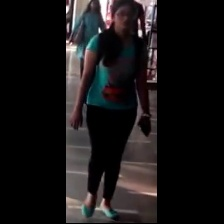


====cutout images=====



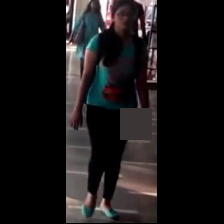

In [19]:
# visualize cutout image here
def view_cutout(imgpath):

  print("====Original image=====\n")
  img = cv2.imread(imgpath)
  cv2_imshow(img)

  print("\n====cutout images=====\n")

  img = img.astype('float32') / 255.
  cutimg = cutout_fxn(img)
  cv2_imshow(cutimg*255)


imgnum = 10
view_cutout(df.image_path.iloc[imgnum])

In [0]:
# applying data augmentation
datagen = ImageDataGenerator(
        # randomly flip images
        #horizontal_flip=True,
        zoom_range = 0.20,
        # set function that will be applied on each input
        preprocessing_function=cutout_fxn
    )

In [21]:
# create train and validation data generators
if data_augmentation_flag:
  print("with image augmentation")
  train_gen = PersonDataGenerator(train_df, batch_size=batchsize, data_augmentation = datagen)
else:
  print("without image augmentation")
  train_gen = PersonDataGenerator(train_df, batch_size=batchsize)

valid_gen = PersonDataGenerator(val_df, batch_size=batchsize, shuffle=False)

without image augmentation


In [22]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
# viewing augmented image, cutout portion 
img_num = 10
if use_google_colab and data_augmentation_flag:
    cv2_imshow(images[img_num]*255)

In [0]:
# viewing augmented image, cutout portion 
img_num = 20
if use_google_colab and data_augmentation_flag:
    cv2_imshow(images[img_num]*255)

### Building ResNet Model

In [42]:
n = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
print("model_type: ",model_type)

model_type:  ResNet32v1


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=False, # old True
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

"""For this assignment, Features maps sizes as below:
    stage 0: 224x224, 16
    stage 1: 112X112, 32
    stage 2: 56X56, 48

    Each stage with 5 block and each block with 2 convolutions.
    Hence total of stages(3) * blocks(5) * convlayer(2) + 2 = 32 layer.
"""
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 8n+2 (eg 20, 32, 44 in [a])')

    # Start model definition.
    num_filters = 16 # increase filter size
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape, name="input")
    #x = resnet_layer(inputs=inputs) # old code
    x = resnet_layer(inputs=inputs, num_filters=num_filters)
    # Instantiate the stack of residual units
    for stack in range(3): # numof stage is modified to 4
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample

            if(strides == 2):
              # replaced 3X3 with Stride=2 by MaxPool and 1X1 kernel
              y = MaxPooling2D(pool_size=(2,2))(x)
              y = resnet_layer(inputs=y,
                               num_filters=num_filters,
                               kernel_size=1)
            else:
              y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims                
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
                #x = Dropout(0.05)(x) # added dropout
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters = num_filters+16

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    #x = AveragePooling2D(pool_size=28)(x) 
    return inputs, x

In [0]:
# define model
def create_model():
  
  minput, backbone = resnet_v1(input_shape=(224,224,3), depth=depth)

  def build_tower(name, in_layer):
      neck = Conv2D(num_units[name], (56,56), use_bias = False)(in_layer) #1X1Xunits
      neck = Flatten()(neck)
      neck = Dense(128, activation="relu")(neck)
      return neck

  def build_head(name, in_layer):
      return Dense(
          num_units[name], activation="softmax", name=f"{name}_output"
      )(in_layer)

  # heads: 
  gender = build_head("gender", build_tower("gender", backbone))
  image_quality = build_head("image_quality", build_tower("image_quality", backbone))
  age = build_head("age", build_tower("age", backbone))
  weight = build_head("weight", build_tower("weight", backbone))
  bag = build_head("bag", build_tower("bag", backbone))
  footwear = build_head("footwear", build_tower("footwear", backbone))
  emotion = build_head("emotion", build_tower("emotion", backbone))
  pose = build_head("pose", build_tower("pose", backbone))

  model = Model(
      inputs=minput, 
      outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
  )

  return model


In [0]:
# create model
model = create_model()

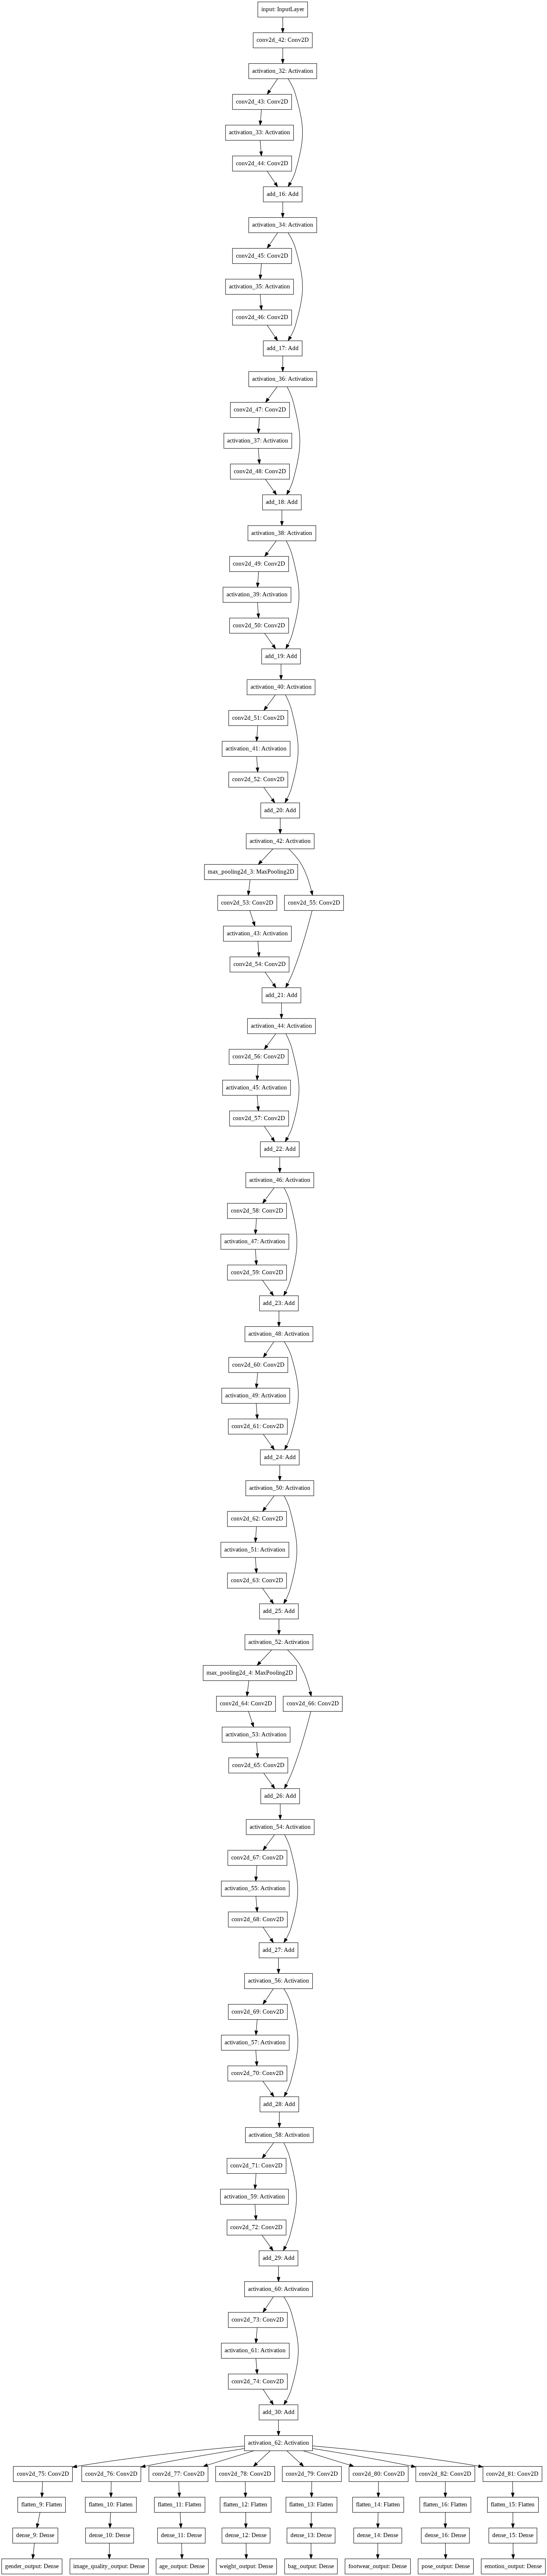

In [46]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='model_plot.png', show_layer_names=True)

In [47]:
print(model_type)
model.summary()

ResNet32v1
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 224, 224, 16) 0           conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 224, 224, 16) 2320        activation_32[0][0]              
_________________________________________________________________________________

In [0]:
losses = {
 	"gender_output": "categorical_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy",
 }

loss_weights = {
 	"gender_output": 1.0,
 	"image_quality_output": 1.0,
 	"age_output": 1.0,
 	"weight_output": 1.0,
  "bag_output": 1.0,
  "footwear_output": 1.0,
  "pose_output": 1.0,
  "emotion_output": 1.0,
 }


opt = SGD(lr=1e-4, momentum=0.9)
model.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
from keras.callbacks import EarlyStopping

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'attempt3_cnn3')
#model_name = 'person_model_best.h5'
model_name = 'person_model.{epoch:03d}.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# using tensorboard callback.
# utility fxn for Initializing Early stopping and Model chekpoint callbacks**
def EarlyStopingModelCheckPoint():
    
    #Adding Early stopping callback to the fit function is going to stop the training,
    #if the val_loss is not going to change even '0.001' for more than 15 continous epochs
    # this help to save training time and not to keep  training if loss does not improve

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

    #Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
    # a new low value. Hence saving the best weights occurred during training
    model_checkpoint =  ModelCheckpoint(filepath=filepath,
                                           monitor='val_loss',
                                           verbose=1,
                                           save_best_only=True,
                                           mode='auto',
                                           period=1)
    return early_stopping, model_checkpoint

In [0]:
from keras.callbacks import *
from keras.optimizers import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
acc_name_list = ["gender_output_acc", "image_quality_output_acc", "age_output_acc", "weight_output_acc", "bag_output_acc",
                  "footwear_output_acc", "pose_output_acc", "emotion_output_acc"]

def plot_model_history_acc(model_history):
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    # summarize history for accuracy
    legend_list = []
    for acc_name in acc_name_list[:4]:
      val_acc_name = 'val_{}'.format(acc_name)
      axs[0].plot(range(1,len(model_history.history[acc_name])+1),model_history.history[acc_name])
      axs[0].plot(range(1,len(model_history.history[val_acc_name])+1),model_history.history[val_acc_name])

      legend_list.append(acc_name)
      legend_list.append(val_acc_name)

    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc_name])+1),len(model_history.history[acc_name])/10)
    axs[0].legend(legend_list, loc='best')


    legend_list = []
    for acc_name in acc_name_list[4:]:
      val_acc_name = 'val_{}'.format(acc_name)
      axs[1].plot(range(1,len(model_history.history[acc_name])+1),model_history.history[acc_name])
      axs[1].plot(range(1,len(model_history.history[val_acc_name])+1),model_history.history[val_acc_name])

      legend_list.append(acc_name)
      legend_list.append(val_acc_name)

    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history[acc_name])+1),len(model_history.history[acc_name])/10)
    axs[1].legend(legend_list, loc='best')

def plot_model_history_loss(model_history):
    fig, axs = plt.subplots(1,figsize=(10,5))

    # summarize history for loss
    axs.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs.set_title('Model Loss')
    axs.set_ylabel('Loss')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Prepare callback for cyclic LR
step_size= 8 * (train_df.shape[0] // batchsize)
MIN_LR = 1e-6
MAX_LR = 1e-3

#Triangular policy
clr_triangular = CyclicLR(mode='triangular', base_lr=MIN_LR, max_lr=MAX_LR, step_size=step_size)

clr_triangular2 = CyclicLR(mode='triangular2', base_lr=MIN_LR, max_lr=MAX_LR, step_size=step_size)

# Exponential policy
#clr_exp = CyclicLR(mode='exp_range', gamma=0.99994, base_lr=MIN_LR, max_lr=MAX_LR, step_size=step_size)
clr_exp = CyclicLR(mode='exp_range', gamma=0.99994, base_lr=MIN_LR, max_lr=MAX_LR, step_size=step_size)

#CLR - Custom Sinusoidal Cycle-Policy
clr_scale_fxn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
clr_sine = CyclicLR(scale_fn=clr_scale_fxn, scale_mode='cycle', base_lr=MIN_LR, max_lr=MAX_LR, step_size=step_size )

clr_used = clr_exp

In [53]:
print("step_size: ", step_size)
print("batchsize: ", batchsize)

step_size:  1440
batchsize:  64


In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping, model_checkpoint = EarlyStopingModelCheckPoint()

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2, #patience=5
                               min_lr=0.1e-7)

callbacks = [early_stopping, model_checkpoint, clr_used]

In [55]:
history = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=96,
    verbose=1, 
    callbacks=callbacks
)

Epoch 1/96
180/180 [==============================] - 91s 507ms/step - loss: 67.3412 - gender_output_loss: 6.9299 - image_quality_output_loss: 7.2342 - age_output_loss: 9.7266 - weight_output_loss: 11.5609 - bag_output_loss: 10.5133 - footwear_output_loss: 10.1391 - pose_output_loss: 6.3305 - emotion_output_loss: 4.6958 - gender_output_acc: 0.5598 - image_quality_output_acc: 0.5505 - age_output_acc: 0.3952 - weight_output_acc: 0.2780 - bag_output_acc: 0.3408 - footwear_output_acc: 0.3688 - pose_output_acc: 0.6062 - emotion_output_acc: 0.7076 - val_loss: 68.7290 - val_gender_output_loss: 7.3035 - val_image_quality_output_loss: 7.2141 - val_age_output_loss: 9.7813 - val_weight_output_loss: 12.4542 - val_bag_output_loss: 10.6831 - val_footwear_output_loss: 10.2282 - val_pose_output_loss: 6.2555 - val_emotion_output_loss: 4.5982 - val_gender_output_acc: 0.5464 - val_image_quality_output_acc: 0.5524 - val_age_output_acc: 0.3931 - val_weight_output_acc: 0.2273 - val_bag_output_acc: 0.3372 - 

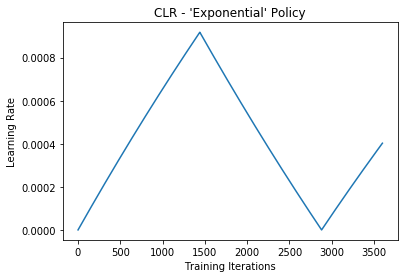

In [56]:
# view how LR has worked
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'Exponential' Policy")
plt.plot(clr_used.history['iterations'], clr_used.history['lr'])

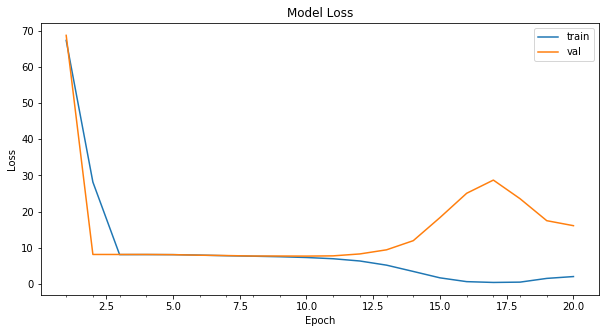

In [57]:
plot_model_history_loss(history)

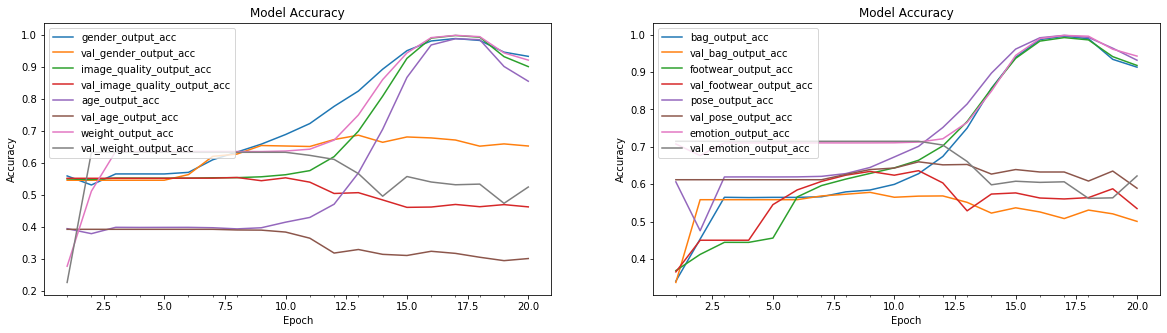

In [58]:
plot_model_history_acc(history)

In [0]:
# Load best saved model
from keras.models import load_model
best_model = load_model("/content/attempt3_cnn3/person_model.010.h5")
#best_model = model

In [60]:
# Evaluate Model for test data
results = best_model.evaluate_generator(valid_gen, verbose=1)
results_dict = dict(zip(best_model.metrics_names, results))

31/31 [==============================] - 5s 177ms/step


In [61]:
# get accuracies for each category
acc_results = {name:result for name, result in zip(best_model.metrics_names, results) if name.endswith("acc")}
print("Total Validation Loss: ", results_dict['loss'])
print("Validation Accuracies: ")
acc_results

Total Validation Loss:  7.6698704534961335
Validation Accuracies: 


{'age_output_acc': 0.3845766129032258,
 'bag_output_acc': 0.5650201612903226,
 'emotion_output_acc': 0.7147177419354839,
 'footwear_output_acc': 0.623991935483871,
 'gender_output_acc': 0.6532258064516129,
 'image_quality_output_acc': 0.5539314516129032,
 'pose_output_acc': 0.6431451612903226,
 'weight_output_acc': 0.6335685483870968}